In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [2]:
df = pd.read_csv("wine-reviews.csv", usecols = ['country', 'description', 'points', 'price', 'variety', 'winery'])

In [3]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [4]:
df = df.dropna(subset=["description", "points"])

In [5]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


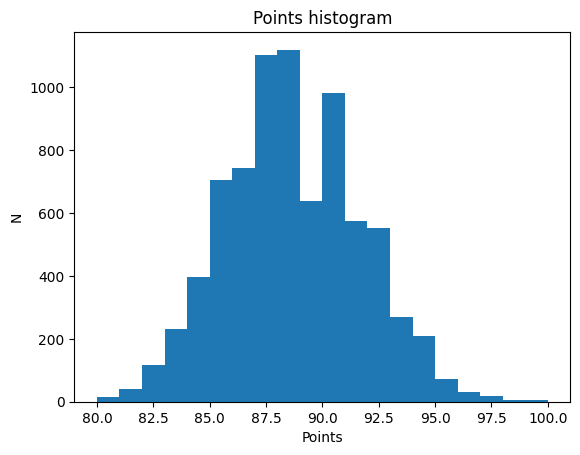

In [6]:
plt.hist(df.points, bins=20)
plt.title("Points histogram")
plt.ylabel("N")
plt.xlabel("Points")
plt.show()

In [7]:
df["label"] = (df.points >= 90).astype(int)
df = df[["description", "label"]]

In [8]:
train, val, test = np.split(df.sample(frac=1), [int(0.8*len(df)), int(0.9*len(df))])

In [9]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df = dataframe.copy()
  labels = df.pop('label')
  df = df["description"]
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [10]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [26]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [27]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.26391608, -0.3909714 , -0.08965056, ..., -0.00217505,
         0.04911781, -0.0806609 ],
       [ 0.45643166, -0.23733154, -0.01197466, ..., -0.09508408,
        -0.07163196,  0.04470788],
       [-0.01161561, -0.16182303, -0.00743872, ...,  0.0071896 ,
        -0.06269511,  0.23531434],
       ...,
       [ 0.5284788 , -0.34635136,  0.05237019, ..., -0.01916962,
        -0.15338396,  0.27940756],
       [ 0.50785613,  0.03045   ,  0.14240238, ..., -0.11236361,
        -0.08171346,  0.06312123],
       [ 0.15339409, -0.20736954, -0.08068281, ...,  0.05062944,
        -0.32715166,  0.05687009]], dtype=float32)>

In [30]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [34]:
model.evaluate(train_data)

7/7 [==============================] - 1s 14ms/step - loss: 0.6909 - accuracy: 0.5526


[0.6908519864082336, 0.5526483654975891]

In [35]:
model.evaluate(valid_data)

1/1 [==============================] - 0s 24ms/step - loss: 0.6882 - accuracy: 0.5619


[0.6881845593452454, 0.5619412660598755]

In [37]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
7/7 [==============================] - 11s 2s/step - loss: 0.6425 - accuracy: 0.6469 - val_loss: 0.6377 - val_accuracy: 0.6373
Epoch 2/10
7/7 [==============================] - 10s 1s/step - loss: 0.6320 - accuracy: 0.6578 - val_loss: 0.6293 - val_accuracy: 0.6360
Epoch 3/10
7/7 [==============================] - 9s 1s/step - loss: 0.6210 - accuracy: 0.6680 - val_loss: 0.6195 - val_accuracy: 0.6373
Epoch 4/10
7/7 [==============================] - 10s 1s/step - loss: 0.6072 - accuracy: 0.6685 - val_loss: 0.6086 - val_accuracy: 0.6424
Epoch 5/10
7/7 [==============================] - 10s 2s/step - loss: 0.5916 - accuracy: 0.6798 - val_loss: 0.5948 - val_accuracy: 0.6628
Epoch 6/10
7/7 [==============================] - 10s 1s/step - loss: 0.5748 - accuracy: 0.7064 - val_loss: 0.5786 - val_accuracy: 0.6820
Epoch 7/10
7/7 [==============================] - 9s 1s/step - loss: 0.5535 - accuracy: 0.7181 - val_loss: 0.5619 - val_accuracy: 0.7024
Epoch 8/10
7/7 [====================

In [38]:
model.evaluate(test_data)

1/1 [==============================] - 0s 186ms/step - loss: 0.5103 - accuracy: 0.7832


[0.510309100151062, 0.7831632494926453]

In [39]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [40]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]


array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'to', 'it', 'its', 'fruit', 'on', 'aromas',
       'palate', 'that'], dtype='<U17')

In [41]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [42]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [43]:
model.evaluate(train_data)
model.evaluate(valid_data)

1/1 [==============================] - 0s 119ms/step - loss: 0.6925 - accuracy: 0.5824


[0.6924961805343628, 0.5823754668235779]

In [44]:
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10
7/7 [==============================] - 8s 346ms/step - loss: 0.6877 - accuracy: 0.6398 - val_loss: 0.6802 - val_accuracy: 0.6373
Epoch 2/10
7/7 [==============================] - 2s 326ms/step - loss: 0.6708 - accuracy: 0.6557 - val_loss: 0.6621 - val_accuracy: 0.6373
Epoch 3/10
7/7 [==============================] - 2s 336ms/step - loss: 0.6470 - accuracy: 0.6557 - val_loss: 0.6531 - val_accuracy: 0.6373
Epoch 4/10
7/7 [==============================] - 2s 322ms/step - loss: 0.6348 - accuracy: 0.6557 - val_loss: 0.6419 - val_accuracy: 0.6373
Epoch 5/10
7/7 [==============================] - 4s 574ms/step - loss: 0.6201 - accuracy: 0.6557 - val_loss: 0.6300 - val_accuracy: 0.6373
Epoch 6/10
7/7 [==============================] - 2s 334ms/step - loss: 0.6059 - accuracy: 0.6557 - val_loss: 0.6146 - val_accuracy: 0.6373
Epoch 7/10
7/7 [==============================] - 2s 337ms/step - loss: 0.5783 - accuracy: 0.6599 - val_loss: 0.5870 - val_accuracy: 0.6462
Epoch 8/10
7/7 [====

In [45]:
model.evaluate(test_data)

1/1 [==============================] - 0s 140ms/step - loss: 0.4833 - accuracy: 0.7793


[0.4833170771598816, 0.7793367505073547]